# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
# Get missing or unknown representation from the feat info df
# turn missing_or_unknown to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Convert any of those missing or unknown representations in
# azdias df to NaNs
# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

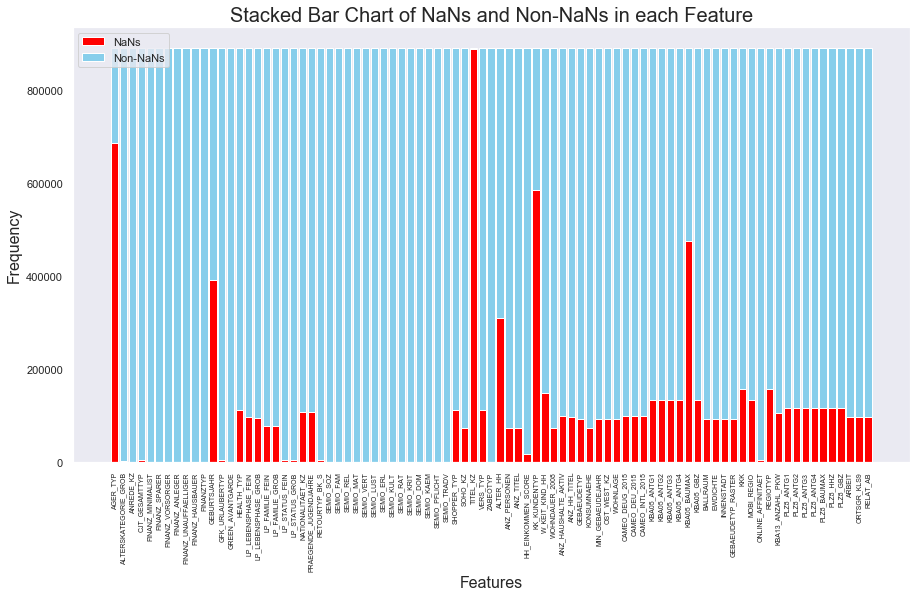

In [6]:
# Investigate patterns in the amount of missing data in each column.

nan_count_per_col = len(azdias) - azdias.count(axis=0)

rcParams['figure.figsize'] = 15, 8
sns.set()
# Create NaNs
plt.bar(np.arange(len(azdias.columns)), nan_count_per_col, color='red', edgecolor='white', label='NaNs')
# Create Non-NaNs
plt.bar(np.arange(len(azdias.columns)), azdias.count(), bottom=nan_count_per_col, color='skyblue', edgecolor='white', label='Non-NaNs')
plt.title('Stacked Bar Chart of NaNs and Non-NaNs in each Feature', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.xticks(np.arange(len(azdias.columns)), azdias.columns, rotation=90, fontsize=7)
plt.grid()
plt.legend(loc='upper left');

In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

bad_col_inds = (azdias.isna().sum() / azdias.shape[0]) > 0.25
azdias = azdias[azdias.columns[~bad_col_inds]]

In [8]:
feat_cols_to_be_removed = list(bad_col_inds[bad_col_inds == True].index)
print(feat_cols_to_be_removed)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [9]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
feat_info[feat_info['attribute'].isin(list(bad_col_inds[bad_col_inds == True].index))]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1, 0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"


#### Discussion 1.1.2: Assess Missing Data in Each Column

__Seems like features such as `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP`, and `KBA05_BAUMAX` have a very high number of missing values in their columns from the bar chart plot, which might not be too useful for us, so we'll remove them and any other columns that have 25% > missing data. In the end, we removed `AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX, RELAT_AB` from our dataset. The attributes with many missing values range from different types and information levels too, so there is not a clear pattern as to why these specific attributes contain many NaNs.__

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?

nan_count_per_row = len(azdias.columns) - azdias.count(axis=1)
nan_count_per_row.mean()

5.649893797385833

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

bad_row_inds = (azdias.isna().sum(axis=1) / azdias.shape[1]) > 0.25
bad_rows = azdias[bad_row_inds]
bad_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
good_rows = azdias[~bad_row_inds]
good_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def feature_countplot(features, good_rows, bad_rows, all_rows):
    '''
    This function plots the counts of each unique value in 
    feature column(s) specified as input for both the dataframe
    with very little missing data and dataframe with alot of 
    missing data

    INPUT: (list) Census Tract feature to be visualized
           (Pandas DataFrame) Dataframe with little missing values
           (Pandas DataFrame) Dataframe with alot of missing values
           (Pandas DataFrame) Dataframe with all rows
    OUTPUT: Countplots of the feature values for both dataframes
    '''
    sns.set()
    fig, axes = plt.subplots(len(features), 3, figsize=(14, 16), sharex=True)
    if len(features) > 1:
        for idx, feat in enumerate(features):
            sns.countplot(x=feat, data=good_rows, color="skyblue", ax=axes[idx, 0])
            sns.countplot(x=feat, data=bad_rows, color="red", ax=axes[idx, 1])
            sns.countplot(x=feat, data=bad_rows, color="green", ax=axes[idx, 2])
    else:
        sns.countplot(x=features[0], data=good_rows, color="skyblue", ax=axes[0])
        sns.countplot(x=features[0], data=bad_rows, color="red", ax=axes[1])
        sns.countplot(x=features[0], data=all_rows, color="green", ax=axes[2])
    plt.legend();

No handles with labels found to put in legend.


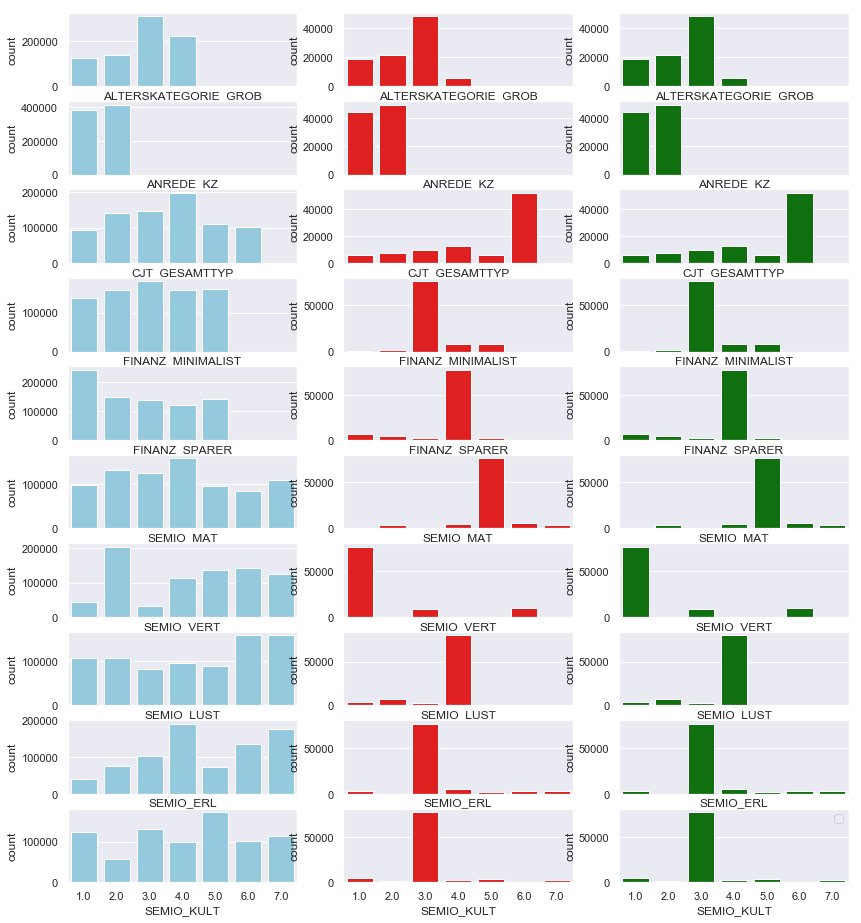

In [15]:
featcols_with_low_missing_vals = list(azdias.columns[:5]) + list(azdias.columns[25:30])
feature_countplot(featcols_with_low_missing_vals, good_rows, bad_rows, azdias);

__Let's also run a Kolmogorov–Smirnov test as well to see if the distributions are indeed statistically significantly different.__

In [16]:
from scipy.stats import ks_2samp

comp_df = pd.DataFrame(azdias.columns, columns=['col'])
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(good_rows, bad_rows, good_rows.columns.values)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df.head()

,col,stats,pvalues
0,ALTERSKATEGORIE_GROB,1.0,0.011066
1,ANREDE_KZ,1.0,0.097027
2,CJT_GESAMTTYP,1.0,0.001300
3,FINANZ_MINIMALIST,1.0,0.003781
4,FINANZ_SPARER,1.0,0.003781


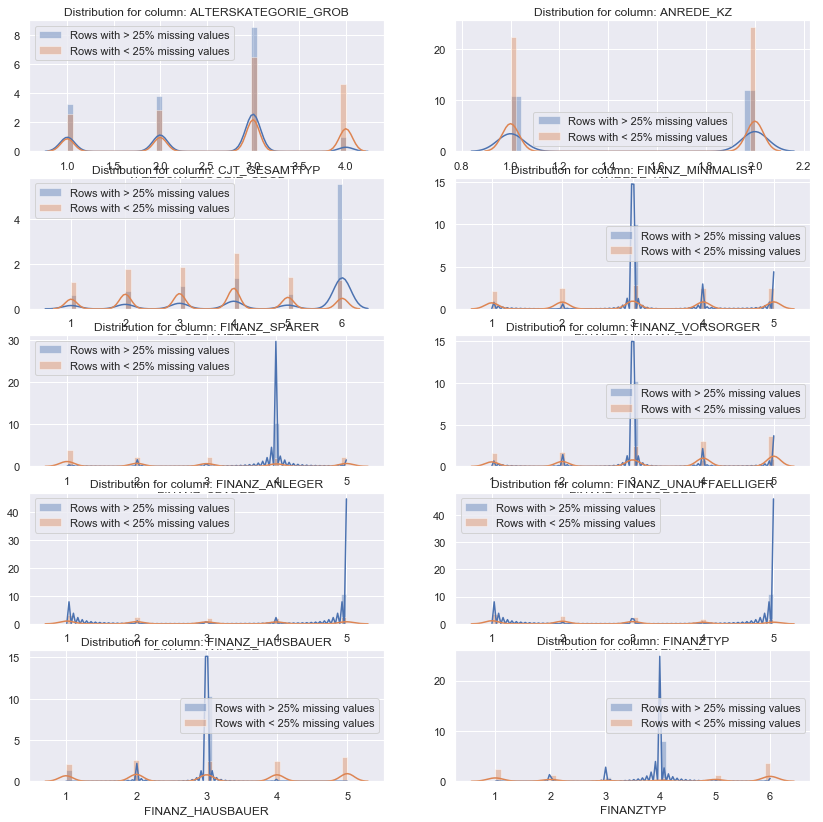

In [17]:
plt.figure(figsize=(14, 14))
for i, col in enumerate(azdias.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(bad_rows[col][bad_rows[col].notnull()], label='Rows with > 25% missing values')
    sns.distplot(good_rows[col][good_rows[col].notnull()], label='Rows with < 25% missing values')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

#### Discussion 1.1.3: Assess Missing Data in Each Row

__After plotting the distribution of values of these feature columns `AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, CJT_GESAMTTYP, FINANZ_MINIMALIST, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL`, we find that though the first 3 columns had value distributions of the "good rows" (rows with little missing data) similar to the "bad rows" (rows with alot of missing data) and also the overall distribution of all the rows, the rest of the feature columns had good row data distributions that are very different from the bad rows and all rows data distribution, which hints to us that the bad rows for these feature columns are highly important to be representative of our overall data distribution.__

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Pandas Series for the number of unique values
# for each of the catgeorical feature columns
num_unique_for_cat_feat = azdias[azdias.columns[azdias.columns.isin(list(feat_info[feat_info['type'] == 'categorical']['attribute']))]].nunique()
num_unique_for_cat_feat

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [20]:
# Before we start cleaning our
# categorical features, let's first 
# find out whether the labels inside the
# general population data is the same as 
# those in our customer data, or else we wouldnt
# be able to properly label encode the  customer data
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [21]:
# Pandas Series for the number of unique values
# for each of the catgeorical feature columns
num_unique_for_cat_feat_customers = customers[customers.columns[customers.columns.isin(list(feat_info[feat_info['type'] == 'categorical']['attribute']))]].nunique()
num_unique_for_cat_feat_customers

AGER_TYP             5
ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     12
LP_FAMILIE_GROB      6
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     4
SHOPPER_TYP          5
SOHO_KZ              2
TITEL_KZ             5
VERS_TYP             3
ZABEOTYP             6
KK_KUNDENTYP         6
GEBAEUDETYP          6
OST_WEST_KZ          2
CAMEO_DEUG_2015     10
CAMEO_DEU_2015      45
dtype: int64

In [22]:
# We only want features that have the same 
# number of labels for general pop and 
# customer data
cat_feats_to_keep = [index for index, row in num_unique_for_cat_feat.iteritems() if index in num_unique_for_cat_feat_customers.index and row == num_unique_for_cat_feat_customers[index] and set(pd.unique(azdias[index])) == set(pd.unique(customers[index]))]
cat_feats_to_keep

['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'ZABEOTYP', 'OST_WEST_KZ']

In [23]:
# Let's take only those features above
num_unique_for_cat_feat = num_unique_for_cat_feat[cat_feats_to_keep]

In [24]:
cat_feats_to_keep

['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'ZABEOTYP', 'OST_WEST_KZ']

In [25]:
# Binary Features
bin_cat_feats = list(num_unique_for_cat_feat[num_unique_for_cat_feat.values == 2].index)
bin_cat_feats

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ']

In [26]:
# Check which ones are numeric already and fall
# into the 1st category of categorical variables
# and which ones are binary but non-numeric
# which need to be LabelEncoded
bin_num_cat_feats = [bin_cat_feat for bin_cat_feat in bin_cat_feats if np.issubdtype(azdias[bin_cat_feat].dtype, np.number)]
azdias[bin_num_cat_feats].head()

,ANREDE_KZ,GREEN_AVANTGARDE
0,1.0,0
1,2.0,0
2,2.0,1
3,2.0,0
4,1.0,0


### Binary Non-Numeric

In [27]:
# Only Column that is binary but not numeric
bin_non_num_cat_feats = [bin_cat_feat for bin_cat_feat in bin_cat_feats if bin_cat_feat not in bin_num_cat_feats]
azdias[bin_non_num_cat_feats].head()

,OST_WEST_KZ
0,NaN
1,W
2,W
3,W
4,W


In [28]:
# Frequency of each occurence in this feature column
pd.value_counts(azdias[bin_non_num_cat_feats].values.flatten())

W    629528
O    168545
dtype: int64

In [29]:
# Before any Encoding though, let's resolve the
# NaNs in our feature columns first - Fill it 
# with the most frequent value
azdias[bin_non_num_cat_feats] = azdias[bin_non_num_cat_feats].fillna(azdias[bin_non_num_cat_feats].describe().loc['top'].values[0])

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn import preprocessing

# Label Encode the Binary Non-Numeric Feature Column
le = preprocessing.LabelEncoder()
azdias[bin_non_num_cat_feats] = le.fit_transform(azdias[bin_non_num_cat_feats].values.ravel())

In [31]:
le.classes_

array(['O', 'W'], dtype=object)

In [32]:
azdias[bin_non_num_cat_feats].head()

,OST_WEST_KZ
0,1
1,1
2,1
3,1
4,1


### Multicategorical

In [33]:
multicategoricals = azdias[[cat_feat for cat_feat in num_unique_for_cat_feat.index if cat_feat not in bin_cat_feats]]
multicategoricals.head()

,FINANZTYP,ZABEOTYP
0,4.0,3.0
1,1.0,5.0
2,1.0,5.0
3,6.0,3.0
4,5.0,4.0


In [34]:
# Remove multicategorical feature columns
# from original dataset and we'll add back
# their onehotencoded versions later
# azdias.drop([cat_feat for cat_feat in num_unique_for_cat_feat.index if cat_feat not in bin_cat_feats], axis=1, inplace=True)

In [35]:
# multicategoricals['CAMEO_DEU_2015'].head()

In [36]:
# Label Encoding Non-numeric multi-level categoricals and
# One-hot encoding of multi-level categoricals, remove first 
# dummy variable to prevent multicollinearity
# multicategoricals['CAMEO_DEU_2015'].fillna(multicategoricals['CAMEO_DEU_2015'].describe().loc['top'], inplace=True)

In [37]:
multicat_label_enc = preprocessing.LabelEncoder()
multicat_label_encoded = multicategoricals.astype(str).apply(multicat_label_enc.fit_transform, axis=0)
multicat_label_encoded.head()

,FINANZTYP,ZABEOTYP
0,3,2
1,0,4
2,0,4
3,5,2
4,4,3


In [38]:
multicat_encoded = pd.concat([pd.get_dummies(multicat_label_encoded[col], drop_first=True) for col in multicat_label_encoded], axis=1, keys=multicat_label_encoded.columns)
multicat_encoded.head()

FINANZTYP             ZABEOTYP            
          1  2  3  4  5        1  2  3  4  5
0         0  0  1  0  0        0  1  0  0  0
1         0  0  0  0  0        0  0  0  1  0
2         0  0  0  0  0        0  0  0  1  0
3         0  0  0  0  1        0  1  0  0  0
4         0  0  0  1  0        0  0  1  0  0

#### Discussion 1.2.1: Re-Encode Categorical Features

__Label Encoded Non-numeric Binary and Multicategorical feature columns and also OneHot encoded the multicategorical feature columns. I removed all the feature columns that had number of unique labels different from the categorical feature columns of the customer dataset else there will be problems later when encoding because an inconsistent number of labels forces us to not be able to use the same encoder on the customer data, which we are supposed to.__

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [39]:
feat_info[feat_info['attribute']=='PRAEGENDE_JUGENDJAHRE']

,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"


In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

__Let's proceed to split this feature column into one for the decade and a binary one for the movement (Mainstream vs Avantgarde)__

In [41]:
# Decoding for the value in the 
# feature column to the two new engineered features
decade_movement_map = {
    1: ('40s', 'm'),
    2: ('40s', 'a'),
    3: ('50s', 'm'),
    4: ('50s', 'a'),
    5: ('60s', 'm'),
    6: ('60s', 'a'),
    7: ('60s', 'a'),
    8: ('70s', 'm'),
    9: ('70s', 'a'),
    10: ('80s', 'm'),
    11: ('80s', 'a'),
    12: ('80s', 'm'),
    13: ('80s', 'a'),
    14: ('90s', 'm'),
    15: ('90s', 'a')
}

In [42]:
# Fill in missing values with most
# frequent value
azdias['PRAEGENDE_JUGENDJAHRE'].fillna(list(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts().index)[0], inplace=True)

# Create Decade Pandas series
decade = pd.Series([decade_movement_map[int(val)][0] for val in azdias['PRAEGENDE_JUGENDJAHRE']])

# Create Movement Pandas series
movement = pd.Series([decade_movement_map[int(val)][1] for val in azdias['PRAEGENDE_JUGENDJAHRE']])

### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [43]:
feat_info[feat_info['attribute']=='CAMEO_INTL_2015']

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [45]:
list(azdias['CAMEO_INTL_2015'].value_counts().index)[0]

'51'

In [46]:
# Fill in missing values with most
# frequent value
azdias['CAMEO_INTL_2015'].fillna(list(azdias['CAMEO_INTL_2015'].value_counts().index)[0], inplace=True)

wealth = pd.Series([int(val)//10 for val in azdias['CAMEO_INTL_2015']])

life_stage = pd.Series([int(val)%10 for val in azdias['CAMEO_INTL_2015']])

__Combine all engineered features in one pandas dataframe__

In [47]:
eng_feats = pd.concat([decade, movement, wealth, life_stage], axis=1, keys=['decade', 'movement', 'wealth', 'life_stage'])
eng_feats.head()

,decade,movement,wealth,life_stage
0,90s,m,5,1
1,90s,m,5,1
2,90s,a,2,4
3,70s,m,1,2
4,70s,m,4,3


__Label and One Hot Encoding TIME__

In [48]:
# Label Encoding engineered features and then
# Onehot encode, remove first 
# dummy variable to prevent multicollinearity
decade_label_enc = preprocessing.LabelEncoder()
movement_label_enc = preprocessing.LabelEncoder()
eng_feats_encoded = pd.concat([pd.DataFrame(decade_label_enc.fit_transform(eng_feats['decade']), index=eng_feats['decade'].index, columns=['decade']), 
                                     pd.DataFrame(movement_label_enc.fit_transform(eng_feats['movement']), index=eng_feats['movement'].index, columns=['movement']), 
                                     eng_feats['wealth'], 
                                     eng_feats['life_stage']], axis=1)
eng_feats_encoded.head()

# Don't Onehot encode because we want to keep the rank order of these interval / ordinal variables
# eng_feats_encoded = pd.concat([pd.get_dummies(eng_feats_label_encoded[col], drop_first=True) for col in eng_feats_label_encoded], axis=1, keys=eng_feats_label_encoded.columns)
# eng_feats_encoded.head()

,decade,movement,wealth,life_stage
0,5,1,5,1
1,5,1,5,1
2,5,0,2,4
3,3,1,1,2
4,3,1,4,3


#### Discussion 1.2.2: Engineer Mixed-Type Features

__Split `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` into 2 engineered features each, applied both Label Encoding to each and will be using them as the only original mixed-Type features to be included in our working dataset. I've finally decided though, that the multicategorical variables are causing way too many problems in terms of properly encoding them because the labels for both the general population and customer dataset must be exactly the same, and also they must both produce the same number of dummy variables, so I've decided to remove them. Furthermore, none of the multicategorical variables showed much feature importance during the PCA analysis when I ran it with the General population data which further supports the reason why I want to do away with them.__

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [49]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [50]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# All numeric, interval, and ordinal type columns
num_inter_ord_df = azdias[azdias.columns[azdias.columns.isin(list(feat_info[feat_info['type'].isin(['numeric', 'interval', 'ordinal'])]['attribute']))]]
num_inter_ord_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,NaN,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0


In [51]:
# Binary Categorical Features
bin_cat_df = azdias[bin_num_cat_feats]
bin_cat_df.head()

,ANREDE_KZ,GREEN_AVANTGARDE
0,1.0,0
1,2.0,0
2,2.0,1
3,2.0,0
4,1.0,0


In [52]:
# Engineered Features (Binary Non-numeric, Multicategorical, Mixed Type)
# eng_df = pd.concat([azdias[bin_non_num_cat_feats], multicat_encoded, eng_feats_encoded], axis=1)
# Removed the multicategorical labels because they
# had inconsistent labels with the customer data
eng_df = pd.concat([azdias[bin_non_num_cat_feats], eng_feats_encoded], axis=1)
eng_df.head()

,OST_WEST_KZ,decade,movement,wealth,life_stage
0,1,5,1,5,1
1,1,5,1,5,1
2,1,5,0,2,4
3,1,3,1,1,2
4,1,3,1,4,3


In [53]:
cleaned_df = pd.concat([num_inter_ord_df, bin_cat_df, eng_df], axis=1)
cleaned_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,OST_WEST_KZ,decade,movement,wealth,life_stage
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,NaN,5.0,2.0,...,NaN,NaN,NaN,1.0,0,1,5,1,5,1
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,3.0,5.0,4.0,2.0,0,1,5,1,5,1
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,3.0,5.0,2.0,2.0,1,1,5,0,2,4
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,2.0,3.0,3.0,2.0,0,1,3,1,1,2
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,4.0,6.0,5.0,1.0,0,1,3,1,4,3


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [54]:
def clean_data(df, feat_info, feat_cols_to_be_removed, cat_feats_to_keep, le, multicat_label_enc, decade_label_enc, movement_label_enc):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, feature information, 
           feature columns removed in general population data,
           categorical features kept by general population data,
           the encoders used by general population data for cleaning
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # remove selected columns and rows, ...

    # Convert any of those missing or unknown representations in
    # azdias df to NaNs
    # Identify missing or unknown data values and convert them to NaNs.
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan

    # Remove the outlier columns from the dataset
    # bad_col_inds = (df.isna().sum() / df.shape[0]) > 0.25
    # df = df[df.columns[~bad_col_inds]]
    df = df.drop(feat_cols_to_be_removed, axis=1)
    
    # select, re-encode, and engineer column values.
    
    ##########################################
    ######### BINARY FEATURE COLUMNS #########
    ##########################################
    num_unique_for_cat_feat = df[df.columns[df.columns.isin(list(feat_info[feat_info['type'] == 'categorical']['attribute']))]].nunique()
    
    # Let's take only those features that are
    # also kept in the general population data
    num_unique_for_cat_feat = num_unique_for_cat_feat[cat_feats_to_keep]
    
    bin_cat_feats = list(num_unique_for_cat_feat[num_unique_for_cat_feat.values == 2].index)

    ##################################################
    ######### BINARY NUMERIC FEATURE COLUMNS #########
    ##################################################
    # Check which ones are numeric already and fall
    # into the 1st category of categorical variables
    # and which ones are binary but non-numeric
    # which need to be LabelEncoded
    bin_num_cat_feats = [bin_cat_feat for bin_cat_feat in bin_cat_feats if np.issubdtype(df[bin_cat_feat].dtype, np.number)]

    ######################################################
    ######### BINARY NON-NUMERIC FEATURE COLUMNS #########
    ######################################################
    # Only Column that is binary but not numeric
    bin_non_num_cat_feats = [bin_cat_feat for bin_cat_feat in bin_cat_feats if bin_cat_feat not in bin_num_cat_feats]

    # Before any Encoding though, let's resolve the
    # NaNs in our feature columns first - Fill it 
    # with the most frequent value
    df[bin_non_num_cat_feats] = df[bin_non_num_cat_feats].fillna(df[bin_non_num_cat_feats].mode())

    # Label Encode the Binary Non-Numeric Feature Column
    df[bin_non_num_cat_feats] = le.transform(df[bin_non_num_cat_feats].values.astype(str).ravel())

    ####################################################
    ######### MULTICATEGORICAL FEATURE COLUMNS #########
    ####################################################
#     multicategoricals = df[[cat_feat for cat_feat in num_unique_for_cat_feat.index if cat_feat not in bin_cat_feats]]

    # Remove multicategorical feature columns
    # from original dataset and we'll add back
    # their onehotencoded versions later
    df = df.drop([cat_feat for cat_feat in num_unique_for_cat_feat.index if cat_feat not in bin_cat_feats], axis=1)

    # Label Encoding Non-numeric multi-level categoricals and
    # One-hot encoding of multi-level categoricals, remove first 
    # dummy variable to prevent multicollinearity
#     multicategoricals['CAMEO_DEU_2015'] = multicategoricals['CAMEO_DEU_2015'].fillna(multicategoricals['CAMEO_DEU_2015'].mode()[0])

#     multicat_label_encoded = multicategoricals.astype(str).apply(multicat_label_enc.transform, axis=0)
#     multicat_encoded = pd.concat([pd.get_dummies(multicat_label_encoded[col], drop_first=True) for col in multicat_label_encoded], axis=1, keys=multicat_label_encoded.columns)

    ##############################################
    ######### MIXED-TYPE FEATURE COLUMNS #########
    ##############################################
    # Decoding for the value in the 
    # feature column to the two new engineered features
    decade_movement_map = {
        1: ('40s', 'm'),
        2: ('40s', 'a'),
        3: ('50s', 'm'),
        4: ('50s', 'a'),
        5: ('60s', 'm'),
        6: ('60s', 'a'),
        7: ('60s', 'a'),
        8: ('70s', 'm'),
        9: ('70s', 'a'),
        10: ('80s', 'm'),
        11: ('80s', 'a'),
        12: ('80s', 'm'),
        13: ('80s', 'a'),
        14: ('90s', 'm'),
        15: ('90s', 'a')
    }

    # Fill in missing values with most
    # frequent value
    df['PRAEGENDE_JUGENDJAHRE'].fillna(list(df['PRAEGENDE_JUGENDJAHRE'].value_counts().index)[0], inplace=True)

    # Create Decade Pandas series
    decade = pd.Series([decade_movement_map[int(val)][0] for val in df['PRAEGENDE_JUGENDJAHRE']])

    # Create Movement Pandas series
    movement = pd.Series([decade_movement_map[int(val)][1] for val in df['PRAEGENDE_JUGENDJAHRE']])

    # Fill in missing values with most
    # frequent value
    df['CAMEO_INTL_2015'].fillna(list(df['CAMEO_INTL_2015'].value_counts().index)[0], inplace=True)

    wealth = pd.Series([int(val)//10 for val in df['CAMEO_INTL_2015']])

    life_stage = pd.Series([int(val)%10 for val in df['CAMEO_INTL_2015']])

    eng_feats = pd.concat([decade, movement, wealth, life_stage], axis=1, keys=['decade', 'movement', 'wealth', 'life_stage'])

    # Don't Onehot encode because we want to keep the rank order of these interval / ordinal variables
#     eng_feats_label_encoded = eng_feats.astype(str).apply(eng_feat_label_enc.transform, axis=0)
#     eng_feats_encoded = pd.concat([pd.get_dummies(eng_feats_label_encoded[col], drop_first=True) for col in eng_feats_label_encoded], axis=1, keys=eng_feats_label_encoded.columns)
#     eng_feats_encoded = pd.concat([pd.get_dummies(eng_feats_label_encoded[col], drop_first=True) for col in eng_feats_label_encoded], axis=1, keys=eng_dummy_train.columns)
    eng_feats_encoded = pd.concat([pd.DataFrame(decade_label_enc.transform(eng_feats['decade']), index=eng_feats['decade'].index, columns=['decade']), 
                                   pd.DataFrame(movement_label_enc.transform(eng_feats['movement']), index=eng_feats['movement'].index, columns=['movement']), 
                                   eng_feats['wealth'], 
                                   eng_feats['life_stage']], axis=1)
    
    ############################################
    ######### SELECTED FEATURE COLUMNS #########
    ############################################
    # All numeric, interval, and ordinal type columns
    num_inter_ord_df = df[df.columns[df.columns.isin(list(feat_info[feat_info['type'].isin(['numeric', 'interval', 'ordinal'])]['attribute']))]]

    # Binary Categorical Features
    bin_cat_df = df[bin_num_cat_feats]

    # Engineered Features (Binary Non-numeric, Multicategorical, Mixed Type)
#     eng_df = pd.concat([df[bin_non_num_cat_feats], multicat_encoded, eng_feats_encoded], axis=1)
    # Removed the multicategorical features because they had inconsistent labels in customer data
    eng_df = pd.concat([df[bin_non_num_cat_feats], eng_feats_encoded], axis=1)

    # Return the cleaned dataframe.
    return pd.concat([num_inter_ord_df, bin_cat_df, eng_df], axis=1)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [55]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

cleaned_df = cleaned_df.fillna(cleaned_df.mode().iloc[0])

In [56]:
# Apply feature scaling to the general population demographics data.
# General population scaler on dataset
gen_pop_sc = preprocessing.StandardScaler()
X_df = pd.DataFrame(gen_pop_sc.fit_transform(cleaned_df), columns=cleaned_df.columns)

/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [57]:
X_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,OST_WEST_KZ,decade,movement,wealth,life_stage
0,-0.751680,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.938197,1.107928,-0.999639,...,0.758890,-0.120115,-0.049267,-1.045218,-0.494701,0.482932,0.994991,0.494701,1.039938,-1.095866
1,-1.743339,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,0.938197,-1.711653,0.541539,...,-0.263506,-0.120115,0.729399,0.956738,-0.494701,0.482932,0.994991,0.494701,1.039938,-1.095866
2,0.239980,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,0.938197,-0.301862,0.027813,...,-0.263506,-0.120115,-0.827934,0.956738,2.021423,0.482932,0.994991,-2.021423,-0.980453,0.879581
3,1.231640,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.385397,-1.006758,0.541539,...,-1.285903,-1.039247,-0.049267,0.956738,-0.494701,0.482932,-0.363493,0.494701,-1.653917,-0.437384
4,0.239980,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,0.938197,1.107928,1.055265,...,0.758890,0.339451,1.508065,-1.045218,-0.494701,0.482932,-0.363493,0.494701,0.366474,0.221098


### Discussion 2.1: Apply Feature Scaling

__Since we still have no idea about which feature columns are useful for our cluster analysis, we shall use all the numeric data, along with all those that were specified above. Filled the rest of the numerical feature columns with the most frequent value (mode) because there weren't that many missing / unknown values in the remaining feature columns that we have, and applied StandardScaling to the entire dataset.__

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
from sklearn import decomposition

pca = decomposition.PCA()
X_pca = pca.fit_transform(X_df)

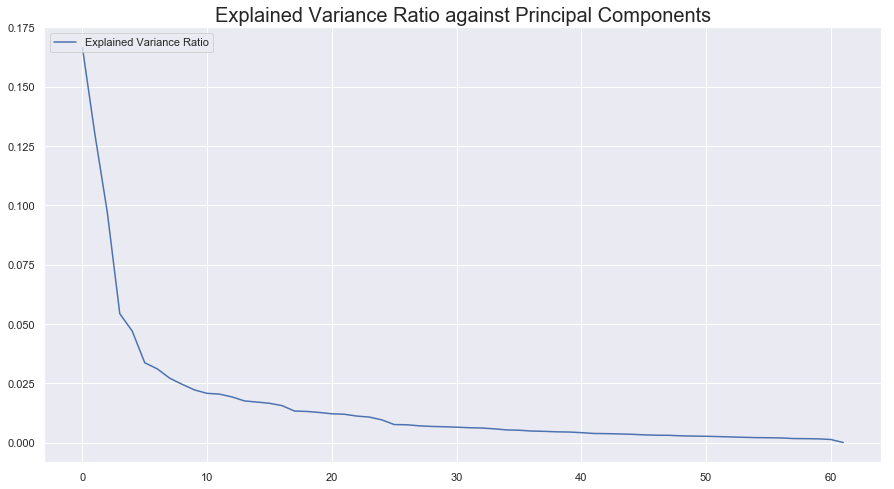

In [59]:
# Plot the explained variance ratio of each principal component
rcParams['figure.figsize'] = 15, 8
sns.set()
plt.title('Explained Variance Ratio against Principal Components', fontsize=20)
plt.plot(pca.explained_variance_ratio_, label='Explained Variance Ratio');
plt.grid(True)
plt.legend(loc='upper left');

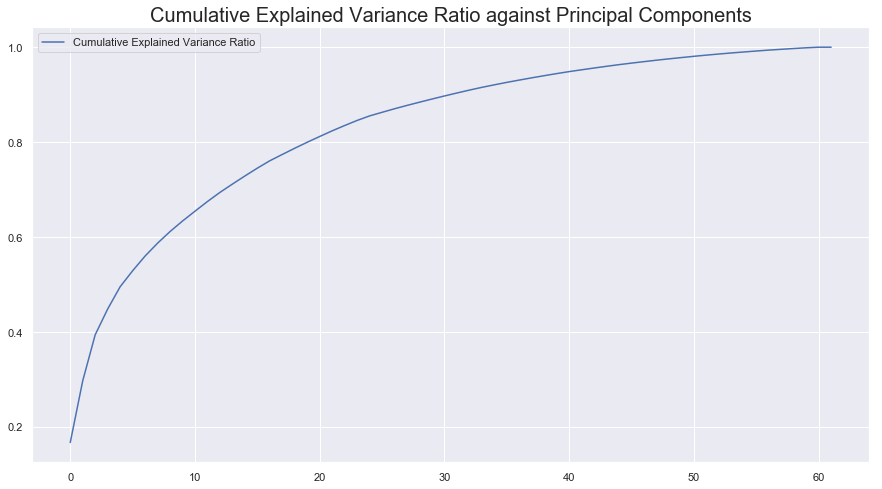

In [60]:
# Find cumulative explained variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

# Plot the explained variance ratio of each principal component
rcParams['figure.figsize'] = 15, 8
sns.set()
plt.title('Cumulative Explained Variance Ratio against Principal Components', fontsize=20)
plt.plot(cum_explained_var, label='Cumulative Explained Variance Ratio');
plt.grid(True)
plt.legend(loc='upper left');

__Since almost all of the cumulative explained variance is captured by the first 60 principal components, and around 30 would have captured 90% of the variance, we shall keep the first 30 principal components.__

In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_reduced = decomposition.PCA(n_components=30)
X_pca = pca_reduced.fit_transform(X_df)

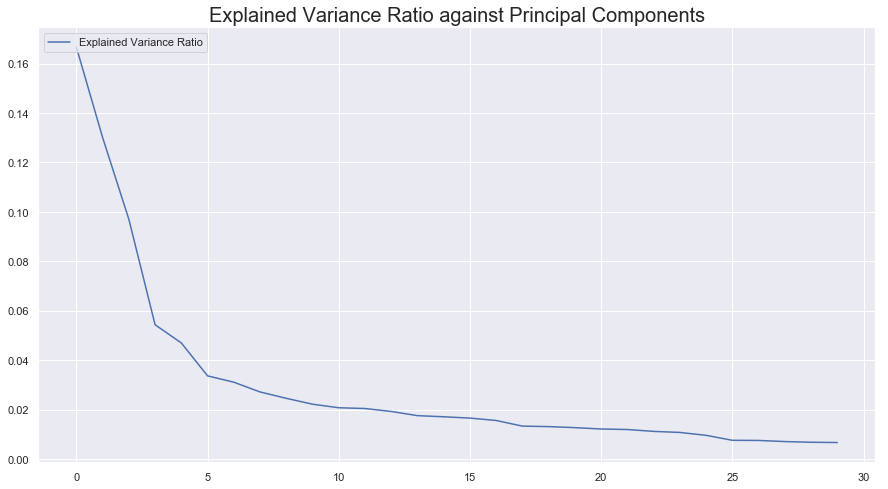

In [62]:
# Plot the explained variance ratio of each principal component
rcParams['figure.figsize'] = 15, 8
sns.set()
plt.title('Explained Variance Ratio against Principal Components', fontsize=20)
plt.plot(pca_reduced.explained_variance_ratio_, label='Explained Variance Ratio');
plt.grid(True)
plt.legend(loc='upper left');

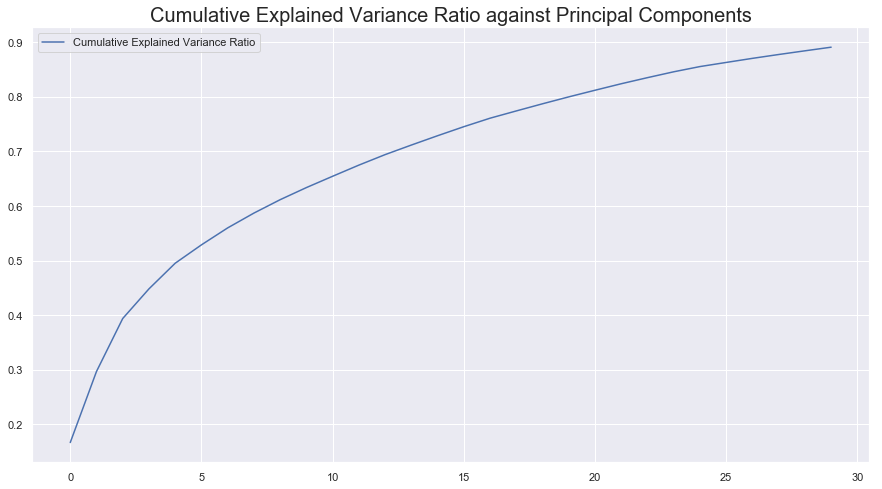

In [63]:
# Find cumulative explained variance
cum_explained_var = []
for i in range(0, len(pca_reduced.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca_reduced.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca_reduced.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

# Plot the explained variance ratio of each principal component
rcParams['figure.figsize'] = 15, 8
sns.set()
plt.title('Cumulative Explained Variance Ratio against Principal Components', fontsize=20)
plt.plot(cum_explained_var, label='Cumulative Explained Variance Ratio');
plt.grid(True)
plt.legend(loc='upper left');

### Discussion 2.2: Perform Dimensionality Reduction

__We retained 30 principal components as they have approximately captured 90% of the explained variance in our cleaned data, so we performed PCA with 30 principal components.__

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [64]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_pc_sorted_weights(df, pc_idx=0):
    return df.loc['PC-{}'.format(pc_idx)].sort_values(ascending=False)

# Create DataFrame with the feature weights for each Principal Component
pca_comp_weights_df = pd.DataFrame(pca_reduced.components_,columns=X_df.columns, index=['PC-{}'.format(idx) for idx in range(pca_reduced.n_components_)])
pca_comp_weights_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,OST_WEST_KZ,decade,movement,wealth,life_stage
PC-0,-0.148929,-0.225589,0.183407,-0.143829,0.119519,0.125006,0.140995,0.065647,-0.040660,0.010379,...,0.147093,0.179067,0.124280,0.017939,-0.120361,-0.034800,0.148284,0.120361,0.206821,-0.141947
PC-1,0.244965,0.039709,-0.225285,0.224122,-0.211427,-0.222795,0.143792,-0.070230,0.166554,-0.057131,...,0.079369,0.132168,0.092293,0.064736,-0.019232,-0.045992,-0.236041,0.019232,0.083884,0.002727
PC-2,0.018550,0.091473,-0.061812,0.040946,-0.170486,-0.096270,-0.022246,-0.059613,0.070359,0.298243,...,0.014742,0.074315,0.045542,-0.342599,0.056161,-0.047500,-0.078903,-0.056161,-0.003874,0.027316
PC-3,-0.089907,-0.064415,0.024192,-0.080824,-0.092675,-0.013287,-0.003979,-0.056367,-0.063132,0.036370,...,-0.004905,0.220178,0.083449,0.137518,0.334365,-0.011656,0.020281,-0.334365,-0.176082,0.155796
PC-4,-0.038656,-0.185657,0.020120,-0.075219,0.048772,-0.162201,0.166982,-0.117589,-0.088821,0.062528,...,-0.090234,-0.118951,-0.056128,0.114726,-0.232203,-0.235396,-0.034328,0.232203,-0.049803,0.132271


In [65]:
# Get 5 most positive and 5 most negative feature weights for PC0 
get_pc_sorted_weights(pca_comp_weights_df, 0).iloc[list(range(5)) + list(range(-5, 0))]

PLZ8_ANTG3           0.219347
wealth               0.206821
EWDICHTE             0.195328
FINANZ_SPARER        0.183407
ORTSGR_KLS9          0.179067
KBA05_GBZ           -0.205453
KBA05_ANTG1         -0.216254
PLZ8_ANTG1          -0.216870
MOBI_REGIO          -0.225163
FINANZ_MINIMALIST   -0.225589
Name: PC-0, dtype: float64

#### FINANZ
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

#### EWDICHTE
Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2

#### PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

#### PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

#### KBA05_GBZ
Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: >=23 buildings

#### KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

#### MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

__Seems like Principal Component 0 seems to be capturing the relationship that "money-saver" households tend to have very high population density and a rather large number of people per home as compared to "low financial interest" households that have very low population density / people per household, which is very logical in our analysis.__

In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Get 5 most positive and 5 most negative feature weights for PC1
get_pc_sorted_weights(pca_comp_weights_df, 1).iloc[list(range(5)) + list(range(-5, 0))]

ALTERSKATEGORIE_GROB     0.244965
FINANZ_VORSORGER         0.224122
SEMIO_ERL                0.212716
SEMIO_LUST               0.168608
RETOURTYP_BK_S           0.166554
SEMIO_PFLICHT           -0.220202
FINANZ_UNAUFFAELLIGER   -0.222795
FINANZ_SPARER           -0.225285
SEMIO_REL               -0.233172
decade                  -0.236041
Name: PC-1, dtype: float64

### ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner

#### FINANZ
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

__Principle Component 1 seems to be capturing relationships more about the age, shopping behavior and personality type.__

In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Get 5 most positive and 5 most negative feature weights for PC2
get_pc_sorted_weights(pca_comp_weights_df, 2).iloc[list(range(5)) + list(range(-5, 0))]

SEMIO_VERT    0.347219
SEMIO_SOZ     0.298243
SEMIO_KULT    0.288784
SEMIO_FAM     0.228960
PLZ8_ANTG4    0.105105
SEMIO_ERL    -0.180347
SEMIO_KRIT   -0.310713
SEMIO_DOM    -0.319533
ANREDE_KZ    -0.342599
SEMIO_KAEM   -0.346164
Name: PC-2, dtype: float64

#### SEMIO
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

#### HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists

__Principal Component 3 on the other hand, seems to be finding relationships between the personality type of the observation and the health type. Those that are more critically reserved (negatively weighted) seem to be correlated with the more critical-minded types, vice versa for those culturally, socially, traditional, dreamful-minded, which again is very logical and is an expected relationship.__

### Discussion 2.3: Interpret Principal Components

__While Principal Component 0 is focused more on explaining the relationship of the income and population density - those with higher income tend to be those that had a lower number of people in the household -, Principle Component 1 is more focused on finding out the correlation between age, personality type, and shopping behavior. Principle Component 2 focused on explaining the relationship between the personality types of observations - those that had more reserved health types tend to be the ones with a more critical mindset. Definitely, a very insightful interpretation of the principal components.__

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
from sklearn.cluster import KMeans

# Calculates the mean distance of each
# point in cluster to centroid
def k_mean_distance(data, centroid_coords, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.sqrt(np.sum([(data_pt_coord - centroid_coords[data_pt_coord_idx])**2 for data_pt_coord_idx, data_pt_coord in enumerate(data_pt_coords)])) for data_pt_coords in data[cluster_labels == i_centroid]]
    # Return the mean value
    return np.mean(distances)

# To store the average distance between data point
# and centroid within each cluster across fitting KMeans
# on 1 to 10 clusters
k_cluster_avg_dist = []

# Over a number of different cluster counts...
for k in range(1, 11):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(X_pca)
    centroids = kmeans.cluster_centers_

    # compute the average within-cluster distances.
    c_mean_distances = []
    for i_centroid, centroid_coords in enumerate(kmeans.cluster_centers_):
        mean_distance = k_mean_distance(X_pca, centroid_coords, i_centroid, clusters)
        c_mean_distances.append(mean_distance)
        
    # Store Mean Average distance between data 
    # points in cluster and respective centroid
    k_cluster_avg_dist.append(np.mean(c_mean_distances))

No handles with labels found to put in legend.


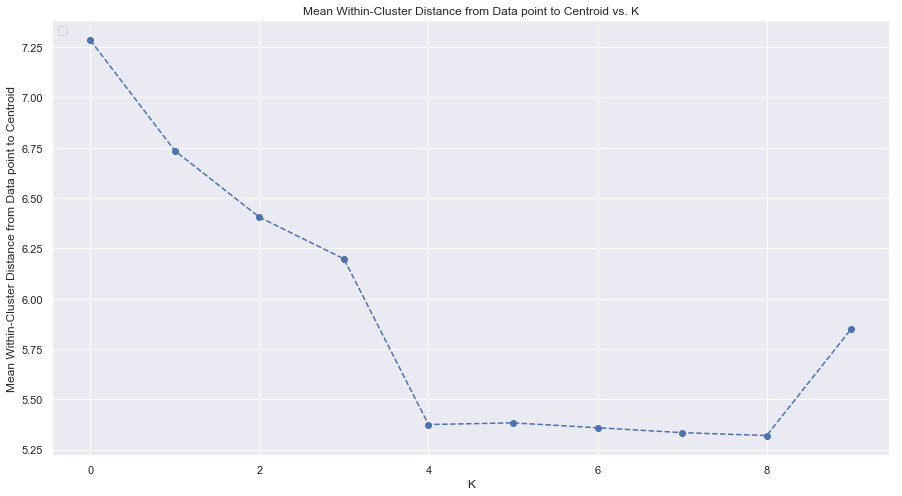

In [69]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

rcParams['figure.figsize'] = 15, 8
sns.set()
plt.plot(k_cluster_avg_dist, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Mean Within-Cluster Distance from Data point to Centroid');
plt.title('Mean Within-Cluster Distance from Data point to Centroid vs. K')
plt.grid(True)
plt.legend(loc='upper left');

In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# run k-means clustering on the data and...
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

# compute the average within-cluster distances.
c_mean_distances = []
for i_centroid, centroid_coords in enumerate(kmeans.cluster_centers_):
    mean_distance = k_mean_distance(X_pca, centroid_coords, i_centroid, clusters)
    c_mean_distances.append(mean_distance)
    
# Average within-cluster distance 
np.mean(c_mean_distances)

6.197911129569663

### Discussion 3.1: Apply Clustering to General Population

__Using the elbow method, it is very clear that the optimal number of classes that we need is k = 4, since it has the lowest Mean Within-cluster distance from all data points to cluster's centroid. Anything above k = 4 increases steadily.__

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [72]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean the customer data similar to general population
cleaned_customer_df = clean_data(customers.fillna(customers.mode().iloc[0]), 
                                 feat_info, 
                                 feat_cols_to_be_removed, 
                                 cat_feats_to_keep, 
                                 le, 
                                 multicat_label_enc, 
                                 decade_label_enc, 
                                 movement_label_enc)

In [73]:
# Apply Standard scaling 
customer_X_df = gen_pop_sc.transform(cleaned_customer_df.fillna(cleaned_customer_df.mode().iloc[0]))

/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [74]:
# Call PCA to reduce dimensions
customer_X_pca = pca_reduced.transform(customer_X_df)

In [75]:
# Create the customer clusters (k = 4)
customer_clusters = kmeans.predict(customer_X_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

No handles with labels found to put in legend.


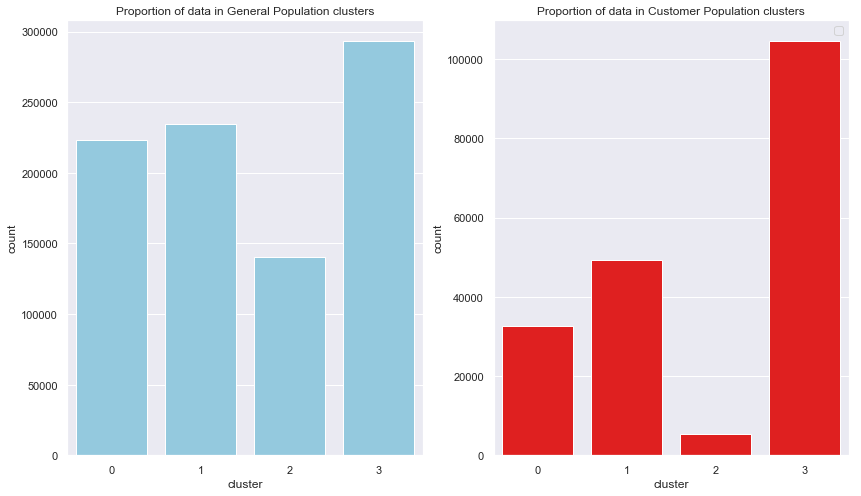

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

clusters_df = pd.DataFrame(clusters, columns=['cluster'])
customer_clusters_df = pd.DataFrame(customer_clusters, columns=['cluster'])

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=True, )
sns.countplot(x='cluster', data=clusters_df, color="skyblue", ax=axes[0])
axes[0].set_title('Proportion of data in General Population clusters')
sns.countplot(x='cluster', data=customer_clusters_df, color="red", ax=axes[1])
axes[1].set_title('Proportion of data in Customer Population clusters')
plt.legend();

__Looks like there's an overwhelming majority of customers that fit the Cluster 2 type and an underrepresentation of Cluster 0, 1, and 3 among our customers.__

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# SUGGESTION from Review #1
# It might be easier to apply the inverse transform 
# only through the PCA transform, then you can take 
# a look at the magnitudes of the scaled coefficients 
# to interpret the values. Since StandardScaler was used, 
# strongly negative values suggest lower values on the original 
# scale and positive values suggest higher values on the original scale.
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns, 
                                        pca_reduced.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

# Find out what the average weights for the first 3 Principal Components are
# for Customer Cluster 2 data
pd.DataFrame(customer_X_pca[customer_clusters_df[customer_clusters_df['cluster'] == 2].index], columns=['PC-{}'.format(idx) for idx in range(pca_reduced.n_components_)]).iloc[:,:3].mean()

PC-0   -0.064465
PC-1   -2.445457
PC-2    3.335332
dtype: float64

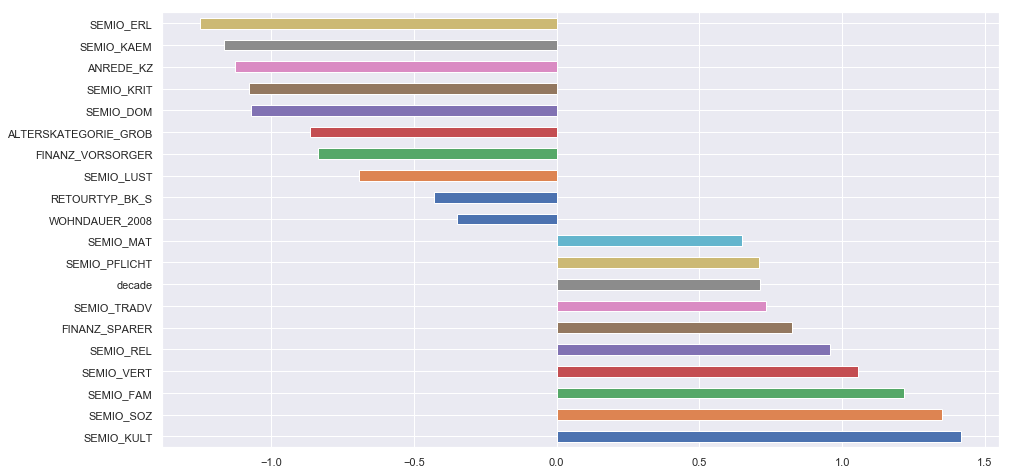

In [78]:
plot_scaled_comparison(cleaned_customer_df, kmeans, 2)

__Since PC-0 has the most negative weight, Cluster 2 can best be interpreted as people that are wealthier, low-financial interest people in small households, and PC-2 suggests that Cluster 2 contain people that have combative attitude and are more likely critically reserved.__

In [79]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Find out what the average weights for the first 3 Principal Components are
# for Customer Cluster 0 data
pd.DataFrame(customer_X_pca[customer_clusters_df[customer_clusters_df['cluster'] == 0].index], columns=['PC-{}'.format(idx) for idx in range(pca_reduced.n_components_)]).iloc[:,:3].mean()

PC-0    0.359509
PC-1    3.986350
PC-2    1.216780
dtype: float64

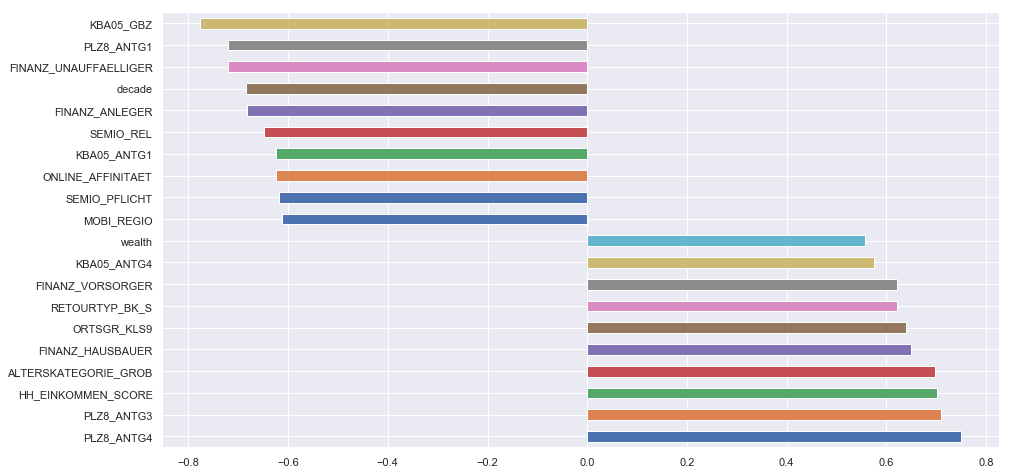

In [80]:
plot_scaled_comparison(cleaned_customer_df, kmeans, 0)

__Since PC-1 has the most positive weight, Cluster 0 can best be interpreted as people that are older, more likely event-oriented / sensual-minded, conservative returner-type, and PC-2 suggests that Cluster 0 contain people that have more cultural, social personality types and sanitary affine.__

In [81]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Find out what the average weights for the first 3 Principal Components are
# for Customer Cluster 0 data
pd.DataFrame(customer_X_pca[customer_clusters_df[customer_clusters_df['cluster'] == 1].index], columns=['PC-{}'.format(idx) for idx in range(pca_reduced.n_components_)]).iloc[:,:3].mean()

PC-0   -0.831401
PC-1   -2.005317
PC-2   -2.219298
dtype: float64

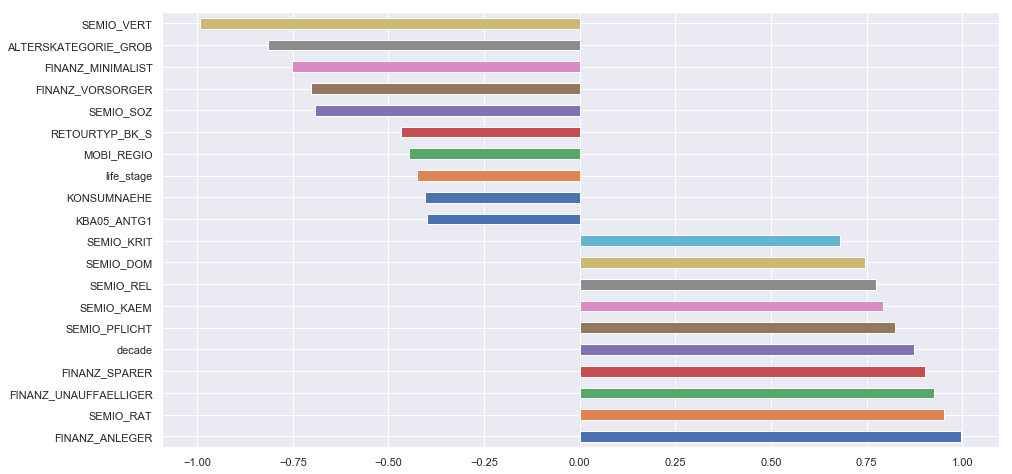

In [82]:
plot_scaled_comparison(cleaned_customer_df, kmeans, 1)

__Both PC-1 and PC-2 are heavily negative in this case, hinting that Cluster 1 people are generally younger people with more inconspicuous spending habits, likely to be investors, but still money-savers, and have a dominant, combative attitude.__

In [83]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Find out what the average weights for the first 3 Principal Components are
# for Customer Cluster 3 data
pd.DataFrame(customer_X_pca[customer_clusters_df[customer_clusters_df['cluster'] == 3].index], columns=['PC-{}'.format(idx) for idx in range(pca_reduced.n_components_)]).iloc[:,:3].mean()

PC-0   -4.342756
PC-1    0.570659
PC-2    1.258773
dtype: float64

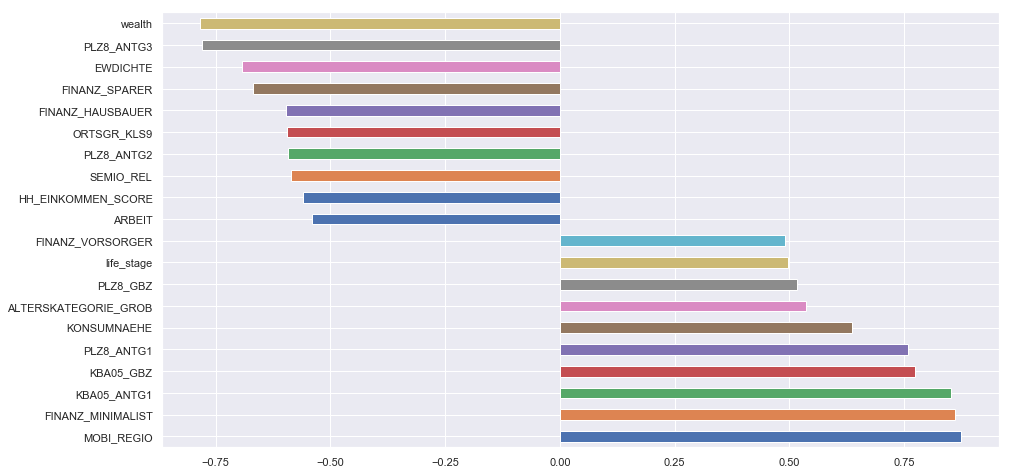

In [84]:
plot_scaled_comparison(cleaned_customer_df, kmeans, 3)

__Looks like Cluster 3 people are cultural, social-minded and money-sparer types since PC-2 has the most positive weight__

### Discussion 3.3: Compare Customer Data to Demographics Data

__It seems pretty clear that Cluster 2 type people will be the main target audience for this company, people that are generally wealthier and live in smaller households. The Cluster 0, 1, and 3 people are  highly underrepresented in the customer population as compared to the general population, suggesting that the mail-order company's products are less attractive to people that are either too old and social or too young and dominant personality type, and in general cultural / social-minded people.__

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.